Celda 1: Importar las bibliotecas necesarias

In [22]:
import mlflow
from mlflow.models import infer_signature

import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import numpy as np

Celda 2: Cargar y preparar el dataset

In [23]:
# Cargar el dataset desde Hugging Face
df = pd.read_csv("US_Accidents_Dec21_updated.csv")

# Mostrar las primeras filas del dataset y su forma
print(df.head())
print(df.shape)

# Seleccionar la variable objetivo y las características
y = df[['Severity']]  # Variable objetivo
X = df[['Temperature(F)', 'Visibility(mi)', 'Wind_Speed(mph)']]  # Características

# Rellenar valores NaN con la mediana
X = X.fillna(X.median())

# Asegurar que X e y tengan las mismas filas
y = y.dropna()
X = X.loc[y.index]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar etiquetas para que comiencen desde 0
y_train = y_train - 1
y_test = y_test - 1

# Convertir y_train a Series
y_train = y_train.squeeze()

    ID  Severity           Start_Time             End_Time  Start_Lat  \
0  A-1         3  2016-02-08 00:37:08  2016-02-08 06:37:08  40.108910   
1  A-2         2  2016-02-08 05:56:20  2016-02-08 11:56:20  39.865420   
2  A-3         2  2016-02-08 06:15:39  2016-02-08 12:15:39  39.102660   
3  A-4         2  2016-02-08 06:51:45  2016-02-08 12:51:45  41.062130   
4  A-5         3  2016-02-08 07:53:43  2016-02-08 13:53:43  39.172393   

   Start_Lng    End_Lat    End_Lng  Distance(mi)  \
0 -83.092860  40.112060 -83.031870         3.230   
1 -84.062800  39.865010 -84.048730         0.747   
2 -84.524680  39.102090 -84.523960         0.055   
3 -81.537840  41.062170 -81.535470         0.123   
4 -84.492792  39.170476 -84.501798         0.500   

                                         Description  ...  Roundabout Station  \
0  Between Sawmill Rd/Exit 20 and OH-315/Olentang...  ...       False   False   
1                 At OH-4/OH-235/Exit 41 - Accident.  ...       False   False   
2    

Celda 3: Configurar la URI de seguimiento de MLflow

In [24]:
# Configurar la URI de seguimiento de MLflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Crear un nuevo experimento en MLflow
mlflow.set_experiment("MLflow Quickstart")

<Experiment: artifact_location='mlflow-artifacts:/855949271339512432', creation_time=1741142958669, experiment_id='855949271339512432', last_update_time=1741142958669, lifecycle_stage='active', name='MLflow Quickstart', tags={}>

Celda 4: Definir los modelos a entrenar

In [25]:
# Definir los modelos a entrenar
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMClassifier(objective='multiclass', num_class=4, metric='multi_logloss', boosting_type='gbdt', learning_rate=0.1),
    #"SVM": SVC(probability=True, kernel='linear'),
    "XGBoost": xgb.XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', learning_rate=0.1),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

Celda 5: Entrenar y registrar múltiples modelos

In [26]:
# Lista para almacenar los resultados de los modelos
model_results = []

# Entrenar y registrar múltiples modelos
for model_name, model in models.items():
    # Finalizar cualquier ejecución activa de MLflow
    mlflow.end_run()

    # Iniciar una nueva ejecución de MLflow
    with mlflow.start_run():
        # Entrenar el modelo
        if model_name == "LightGBM":
            train_data = lgb.Dataset(X_train, label=y_train)
            test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
            evals_result = {}
            model = lgb.train(
                model.get_params(),
                train_data,
                valid_sets=[train_data, test_data],
                valid_names=['train', 'test'],
                num_boost_round=100,
                callbacks=[lgb.log_evaluation(10), lgb.record_evaluation(evals_result)]
            )
            y_pred = model.predict(X_test)
            y_pred = y_pred.argmax(axis=1)
            train_loss = evals_result['train']['multi_logloss']
            test_loss = evals_result['test']['multi_logloss']
            print(f"{model_name} training completed.")
        elif model_name == "XGBoost":
            evals_result = {}
            model.set_params(eval_metric='mlogloss')
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
            y_pred = model.predict(X_test)
            evals_result = model.evals_result()
            train_loss = evals_result['validation_0']['mlogloss']
            test_loss = evals_result['validation_1']['mlogloss']
            print(f"{model_name} training completed.")
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            train_loss = None
            test_loss = None
            if model_name == "KNN":
                print(f"{model_name} training completed.")

        # Calcular la precisión
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{model_name} Accuracy: {accuracy:.4f}")

        # Registrar la métrica de precisión en MLflow
        mlflow.log_metric("accuracy", accuracy)

        # Registrar las métricas de pérdida (loss) en MLflow para LightGBM y XGBoost
        if model_name in ["LightGBM", "XGBoost"]:
            for i, (train, test) in enumerate(zip(train_loss, test_loss)):
                try:
                    mlflow.log_metric("train_loss", train, step=i)
                    mlflow.log_metric("test_loss", test, step=i)
                except Exception as e:
                    print(f"Error logging metric at step {i}: {e}")

        # Inferir la firma del modelo
        signature = infer_signature(X_train, model.predict(X_train))

        # Registrar el modelo en MLflow
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            signature=signature,
            input_example=X_train
        )

        # Agregar etiquetas
        mlflow.set_tag("Model", model_name)

        # Almacenar los resultados del modelo
        model_results.append({
            'model_name': model_name,
            'accuracy': accuracy,
            'train_loss': train_loss,
            'test_loss': test_loss
        })

d:\Documentos_Loni\EspecializacionIA_Autonoma_02-09-2024\3.Desarrollo_de_Proyectos_de_IA\7.Modulo4\Proyecto6_Mlflow\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.8905


2025/03/05 21:54:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run stately-trout-1 at: http://127.0.0.1:5000/#/experiments/855949271339512432/runs/1733929d626f4eb782456e170c7554d9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/855949271339512432
Random Forest Accuracy: 0.8890


2025/03/05 21:57:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run burly-jay-504 at: http://127.0.0.1:5000/#/experiments/855949271339512432/runs/a27bcb43dd134b64a63bb02222b2c445
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/855949271339512432
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 2276273, number of used features: 3
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Start training from score -4.692413
[LightGBM] [Info] Start training from score -0.116361
[LightGBM] [Info] Start training from score -2.908232
[LightGBM] [Info] Start training from score -3.076744
[10]	train's multi_logloss: 0.412036	test's multi_logloss: 0.411

2025/03/05 21:58:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run blushing-mouse-681 at: http://127.0.0.1:5000/#/experiments/855949271339512432/runs/6a4a82d63180428b91b08b0ecdc58b9f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/855949271339512432
XGBoost training completed.
XGBoost Accuracy: 0.8906


2025/03/05 21:59:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run rare-squirrel-867 at: http://127.0.0.1:5000/#/experiments/855949271339512432/runs/abb5a4fc783544ffb4eef40d1fe8a822
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/855949271339512432
KNN training completed.
KNN Accuracy: 0.8845


2025/03/05 22:03:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run clumsy-goat-721 at: http://127.0.0.1:5000/#/experiments/855949271339512432/runs/f131aa46cf664a2e9cb7e241796f9a34
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/855949271339512432


Celda 6: Graficar la evolución de la pérdida para cada modelo

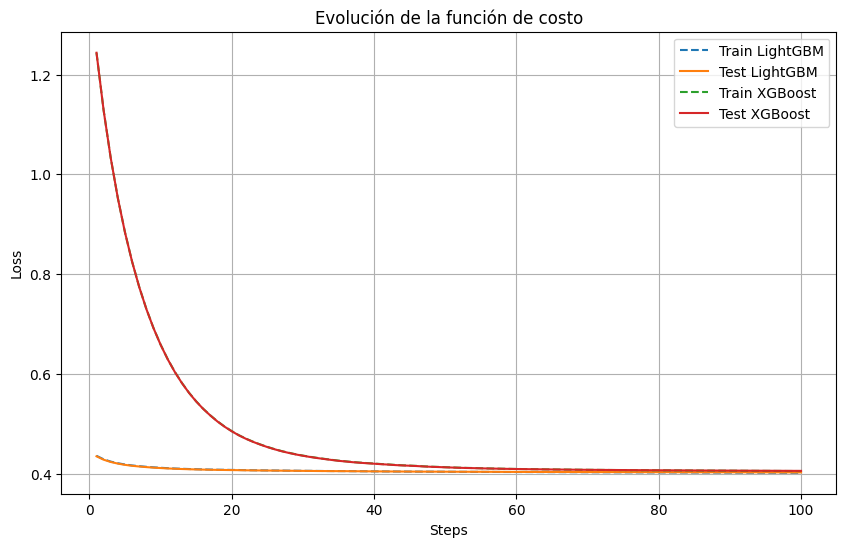

In [27]:
# Graficar la evolución de la pérdida para cada modelo
plt.figure(figsize=(10, 6))
for result in model_results:
    if result['train_loss'] is not None:
        epochs = range(1, len(result['train_loss']) + 1)
        plt.plot(epochs, result['train_loss'], label=f"Train {result['model_name']}", linestyle='--')
        plt.plot(epochs, result['test_loss'], label=f"Test {result['model_name']}")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Evolución de la función de costo")
plt.legend()
plt.grid()
plt.show()